In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

training_data_path = r"J:\Temp\train"
testing_data_path = r"J:\Temp\test"

classes = ['nothing', 'pin']

resize_image_height = 256
resize_image_width = 256

if not os.path.exists(training_data_path):
    print("Could not find folder: " + training_data_path)
    raise

if not os.path.exists(testing_data_path):
    print("Could not find folder: {}".format(testing_data_path))
    raise

In [2]:
from sklearn.model_selection import train_test_split

training_globs = []
testing_globs = []

num_classes = len(classes)

print("Number of classes: {}".format(num_classes))

for i in range(num_classes):
    training_class_path = os.path.join(training_data_path, classes[i])
    testing_class_path = os.path.join(testing_data_path, classes[i])
    
    training_class_glob = glob(os.path.join(training_class_path, "*.png"))
    testing_class_glob = glob(os.path.join(testing_class_path, "*.png"))
    
    training_globs.append(training_class_glob)
    testing_globs.append(testing_class_glob)

Number of classes: 2


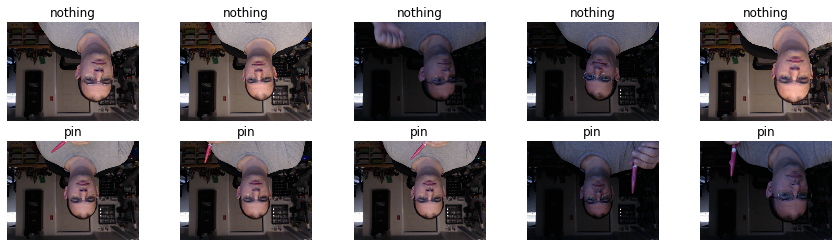

In [3]:
# Show sample images of all classes

num_choices = 5
random_choices = []
labels = []

for i in range(num_classes):
    random_choice = np.random.choice(training_globs[i], num_choices)
    random_choices.append(random_choice)
    labels.append(num_choices * [classes[i]])

plt.figure(figsize=(3*num_choices,2*num_classes))

for class_index in range(num_classes):
    for choice_index in range(num_choices):
        im = Image.open(random_choices[class_index][choice_index]).convert('RGB')
        plt.subplot(num_classes, num_choices, class_index * num_choices + choice_index + 1)
        plt.title(labels[class_index][choice_index])
        plt.imshow(np.asarray(im))
        plt.axis('off')

In [4]:
# Model customization

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

# setup model

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning

for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(resize_image_height, resize_image_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
    testing_data_path,
    target_size=(resize_image_height, resize_image_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1163 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [6]:
num_epochs = 3
steps_per_epoch = int(train_generator.n / batch_size)
validation_steps = int(test_generator.n / batch_size)

history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
36/36 [==============================] - 36s 996ms/step - loss: 0.7145 - acc: 0.6102 - val_loss: 0.5609 - val_acc: 0.6562
Epoch 2/3
36/36 [==============================] - 32s 876ms/step - loss: 0.5218 - acc: 0.7356 - val_loss: 0.6003 - val_acc: 0.7091
Epoch 3/3
36/36 [==============================] - 32s 899ms/step - loss: 0.4309 - acc: 0.8038 - val_loss: 0.3073 - val_acc: 0.8727


In [7]:
test_generator.reset()
x,y = test_generator.next()

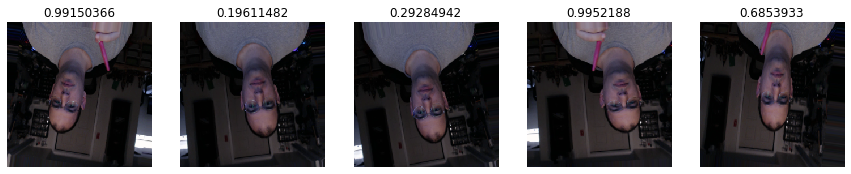

In [9]:
num_choices = 5
test_indices = range(batch_size)

random_choice = np.random.choice(test_indices, num_choices)

plt.figure(figsize=(3*num_choices, 3))

for i in range(num_choices):
    im = x[random_choice[i]][:,:,:]
    prediction = model.predict(np.expand_dims(im, 0))
    plt.subplot(1, num_choices, i+1)
    plt.title(str(prediction[0][1]))
    plt.imshow((im + 1)/2)
    plt.axis('off')